# Visual Question Answering on CLEVR dataset

In [1]:
#importing libraries
!pip install tensorflow_datasets
import numpy as np
import pandas as pd   
import os
from pathlib import Path
import glob
import json
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import nltk
import cv2
import matplotlib.pyplot as plt
import random

     |████████████████████████████████| 3.3 MB 5.0 MB/s eta 0:00:01


In [2]:
#check GPU is available for training or not
physical_devices = tf.config.list_physical_devices('GPU') 
print("Number of GPUs :", len(physical_devices)) 
print("Tensorflow GPU :",tf.test.is_built_with_cuda())
if len(physical_devices)>0:
    device="/GPU:0"
else:
    device="/CPU:0"

Number of GPUs : 1
Tensorflow GPU : True


# Loading the data from the JSON files 
Loading the json files using JSON module and using pandas to create a dataframe consisting of the path to the images and respective questions and answers to the images.

In [3]:
#train_dataframe and val_dataframe stores the path to the images and respective questions and answers
trainList=[]
with open('/kaggle/input/clevr-dataset/CLEVR_v1.0/questions/CLEVR_train_questions.json') as f:
    data = json.load(f)
    for i in data['questions']:
        temp=[]
        for path in glob.glob('/kaggle/input/clevr-dataset/CLEVR_v1.0/images/train/'+i['image_filename']): 
            temp.append(path)
        temp.append(i['question'])
        temp.append(i['answer'])
        trainList.append(temp)
f.close()
labels=['Path','Question','Answer']
train_dataframe = pd.DataFrame.from_records(trainList, columns=labels)#training Dataframe 
del(data)
del(trainList)

valList=[]
with open('/kaggle/input/clevr-dataset/CLEVR_v1.0/questions/CLEVR_val_questions.json') as f:
    data = json.load(f)
    for i in data['questions']:
        temp=[]
        for path in glob.glob('/kaggle/input/clevr-dataset/CLEVR_v1.0/images/val/'+i['image_filename']): 
            temp.append(path)
        temp.append(i['question'])
        temp.append(i['answer'])
        valList.append(temp)
f.close()
val_dataframe = pd.DataFrame.from_records(valList, columns=labels)#validation Dataframe
del(data)
del(valList)
val_dataframe.head()

,Path,Question,Answer
0,/kaggle/input/clevr-dataset/CLEVR_v1.0/images/...,Are there any other things that are the same s...,no
1,/kaggle/input/clevr-dataset/CLEVR_v1.0/images/...,Is there a big brown object of the same shape ...,yes
2,/kaggle/input/clevr-dataset/CLEVR_v1.0/images/...,What is the material of the big purple object?,metal
3,/kaggle/input/clevr-dataset/CLEVR_v1.0/images/...,There is a small gray block; are there any sph...,yes
4,/kaggle/input/clevr-dataset/CLEVR_v1.0/images/...,Is the purple thing the same shape as the larg...,no


# Vocabulary set of the questions
prepare a vocabulary set for questions and answers present in the dataset, it will be used to create an encoder

In [4]:
vocab_set=set()#set object used to store the vocabulary

tokenizer = tfds.features.text.Tokenizer()
for i in val_dataframe['Question']:
    vocab_set.update(tokenizer.tokenize(i))
for i in train_dataframe['Question']:
    vocab_set.update(tokenizer.tokenize(i))
for i in val_dataframe['Answer']:
    vocab_set.update(tokenizer.tokenize(i))
for i in train_dataframe['Answer']:
    vocab_set.update(tokenizer.tokenize(i))


# Creating an Encoder and a Function to preprocess the text data during the training and inference

In [5]:
#Creating an encoder
encoder=tfds.features.text.TokenTextEncoder(vocab_set)
index=14
print("Testing the Encoder with sample questions - \n ")
example_text=encoder.encode(train_dataframe['Question'][index])
print("Original Text = "+train_dataframe['Question'][index])
print("After Encoding = "+str(example_text))

Testing the Encoder with sample questions - 
 
Original Text = There is a small matte block that is on the left side of the large rubber thing that is left of the gray ball; what is its color?
After Encoding = [95, 83, 43, 4, 29, 37, 33, 83, 97, 12, 85, 18, 93, 12, 66, 59, 75, 33, 83, 85, 93, 12, 46, 11, 74, 83, 41, 15]


# Creating Input pipeline for the model

In [6]:
BATCH_SIZE=8
IMG_SIZE=(200,200)


#encode the input question and answer string
def encode_fn(text):
    return np.array(encoder.encode(text.numpy()))


#Function to load and decode the image from the file paths in the dataframe and use the encoder function
def preprocess(ip,ans):
    img,ques=ip#ip is a list containing image paths and questions
    img=tf.io.read_file(img)
    img=tf.image.decode_jpeg(img,channels=3)
    img=tf.image.resize(img,IMG_SIZE)
    img=tf.math.divide(img, 255)#The image has been loaded , decoded and resized 
    
    #The question string is converted to encoded list with fixed size of 50 with padding with 0 value
    ques=tf.py_function(encode_fn,inp=[ques],Tout=tf.int32)
    paddings = [[0, 50-tf.shape(ques)[0]]]
    ques = tf.pad(ques, paddings, 'CONSTANT', constant_values=0)
    ques.set_shape([50])#Explicit shape must be defined in order to create the Input pipeline
    
    #The Answer is also encoded 
    ans=tf.py_function(encode_fn,inp=[ans],Tout=tf.int32)
    ans.set_shape([1])
    
    return (img,ques),ans
    
def create_pipeline(dataframe):
    raw_df=tf.data.Dataset.from_tensor_slices(((dataframe['Path'],dataframe['Question']),dataframe['Answer']))
    df=raw_df.map(preprocess)#Preprocessing function is applied to the dataset
    df=df.batch(BATCH_SIZE)#The dataset is batched
    return df

#The training and validation Dataset objects are created
train_dataset=create_pipeline(train_dataframe)
validation_dataset=create_pipeline(val_dataframe)

# Creating the Model

In [7]:
#Creating the CNN model for image processing


CNN_Input=tf.keras.layers.Input(shape=(200,200,3),name='image_input')

mobilenetv2=tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(200,200,3), alpha=1.0, include_top=False,
                                                      weights='imagenet', input_tensor=CNN_Input)

CNN_model=tf.keras.models.Sequential()
CNN_model.add(CNN_Input)
CNN_model.add(mobilenetv2)
CNN_model.add(tf.keras.layers.GlobalAveragePooling2D())


#Creating the RNN model for text processing
RNN_model=tf.keras.models.Sequential()
RNN_Input=tf.keras.layers.Input(shape=(50),name='text_input')
RNN_model.add(RNN_Input)
RNN_model.add(tf.keras.layers.Embedding (len(vocab_set)+1,256))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform')))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform')))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,stateful=False,return_sequences=False,recurrent_initializer='glorot_uniform')))


concat=tf.keras.layers.concatenate([CNN_model.output,RNN_model.output])
dense_out=tf.keras.layers.Dense(len(vocab_set),activation='softmax',name='output')(concat)

model = tf.keras.Model(inputs=[CNN_Input,RNN_Input],
                    outputs=dense_out)
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model.summary()

/opt/conda/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 256)      25856       text_input[0][0]                 
__________________________________________________________________________________________________
image_input (InputLayer)        [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 50, 512)      1050624     embedding[0][0]                  
_______________________________

# Training the model on the prepared data

In [8]:
def scheduler(epoch):
  if epoch < 1:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (1 - epoch))

LRS = tf.keras.callbacks.LearningRateScheduler(scheduler)
csv_callback=tf.keras.callbacks.CSVLogger(
    "Training Parameters.csv", separator=',', append=False
)
with tf.device(device):
    model.fit(train_dataset,
              validation_data=validation_dataset,
              callbacks=[csv_callback,LRS],
              epochs=2)

Train for 87499 steps, validate for 18749 steps
Epoch 1/2
87499/87499 [==============================] - 8501s 97ms/step - loss: 1.0464 - sparse_categorical_accuracy: 0.4336 - val_loss: 1.0017 - val_sparse_categorical_accuracy: 0.4584
Epoch 2/2
87499/87499 [==============================] - 8487s 97ms/step - loss: 0.9972 - sparse_categorical_accuracy: 0.4557 - val_loss: 0.9935 - val_sparse_categorical_accuracy: 0.4640


# Looking At the training results

Predictions Are as follows = 


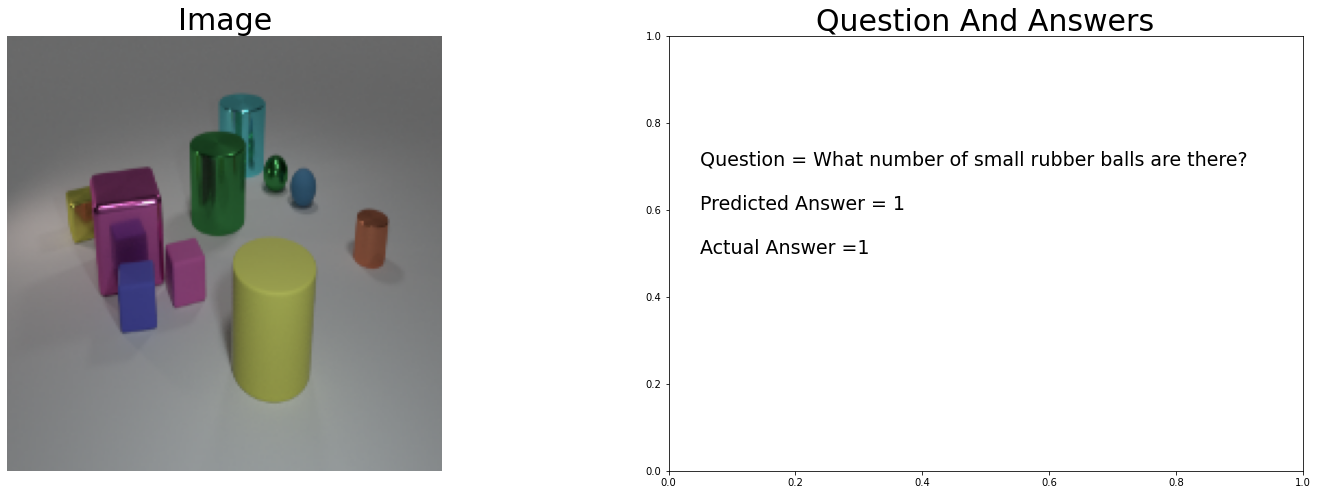

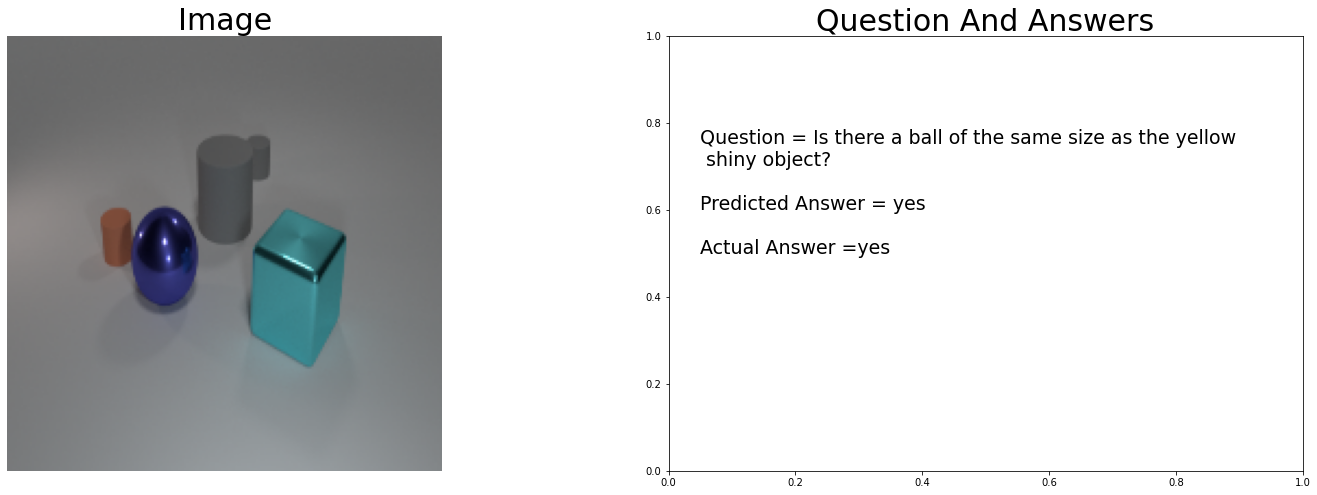

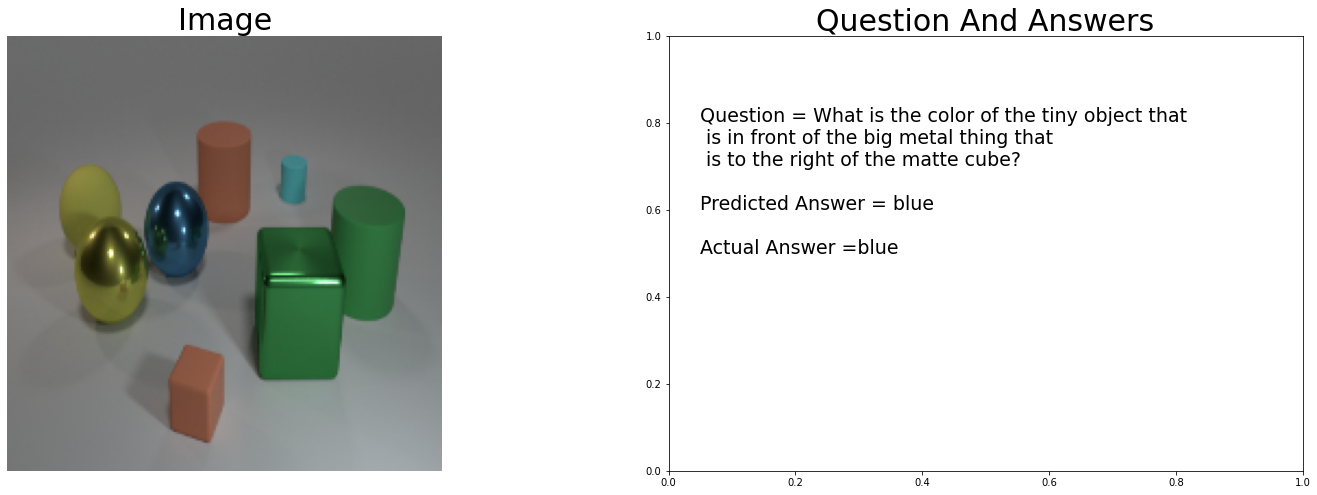

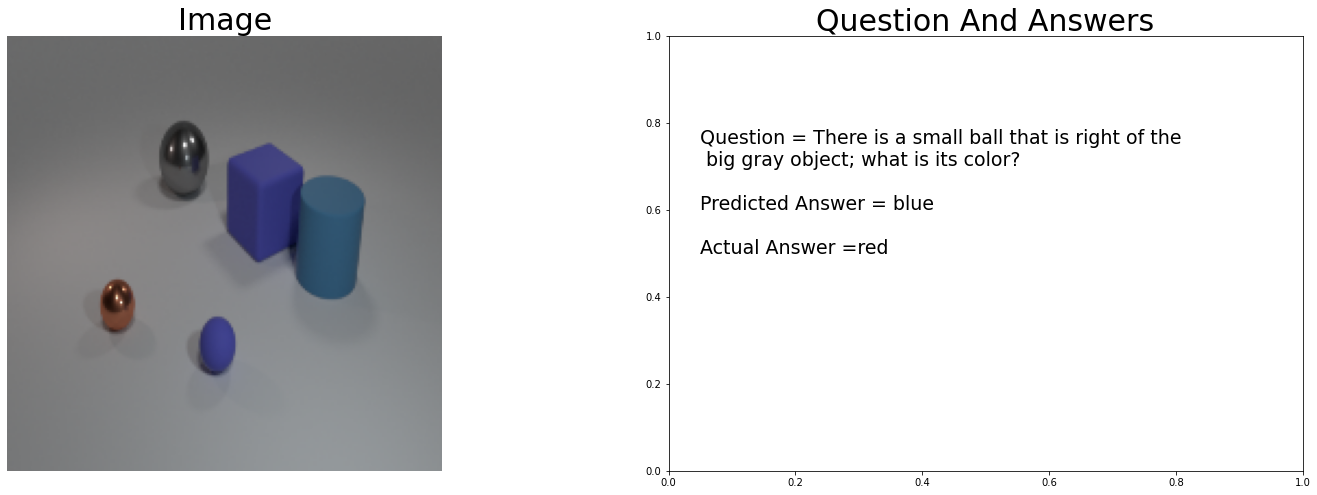

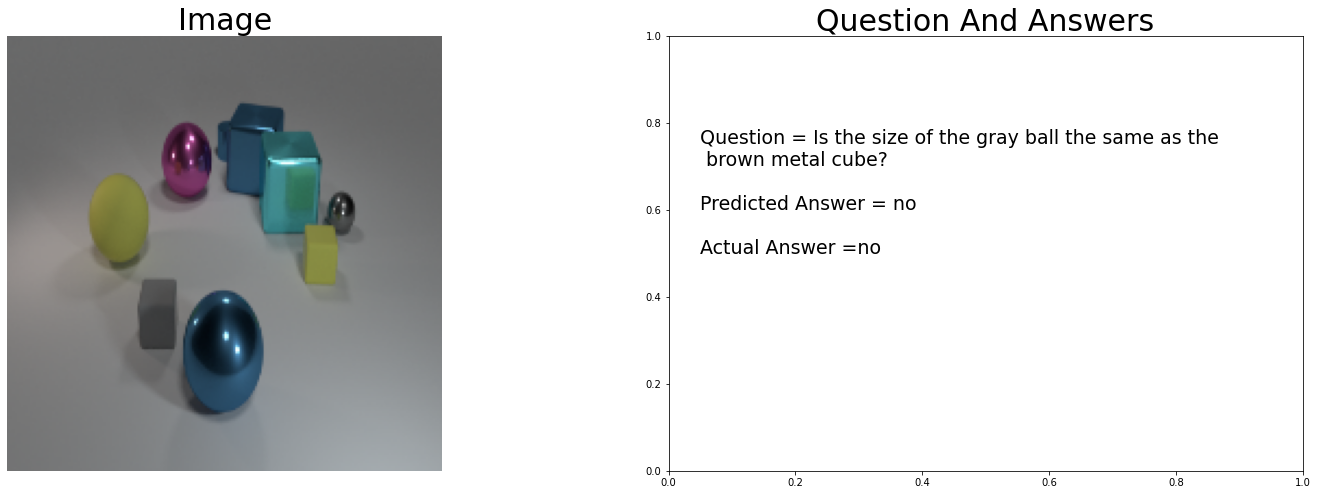

In [14]:
print("Predictions Are as follows = ")
for i in range(5):
    index=random.randrange(20, 5000, 3)
    fig,axis=plt.subplots(1,2,figsize=(25, 8))
    im=cv2.imread(val_dataframe.iloc[index]['Path'])
    im=cv2.resize(im,(200,200))
    q=val_dataframe.iloc[index]['Question']
    q=encoder.encode(q)
    paddings = [[0, 50-tf.shape(q)[0]]]
    q=tf.pad(q, paddings, 'CONSTANT', constant_values=0)
    q=np.array(q)
    ans=model.predict([[im],[q]])
    question=""
    flag=0
    for i,j in enumerate(val_dataframe.iloc[index]['Question']):
        if (flag==1) and (j==' '):
            question+='\n'
            flag=0
        question+=j
        if (i%40==0)and (i!=0):
            flag=1
    axis[0].imshow(im)
    axis[0].axis('off')
    axis[0].set_title('Image', fontsize=30)
    axis[1].text(0.05,0.5,
             "Question = {}\n\nPredicted Answer = {}\n\nActual Answer ={}".format(question,encoder.decode([np.argmax(ans)]),val_dataframe.iloc[index]['Answer']),
             transform=plt.gca().transAxes,fontsize=19)
    axis[1].axis('on')
    axis[1].set_title('Question And Answers', fontsize=30)
